In [6]:
import os
iskaggle = os.environ.get('KAGGLE_KERNAL_RUN_TYPE','')

In [2]:
import pandas as pd
df = pd.read_csv('Reddit_Data.csv')
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [8]:
df.isna().sum()

clean_comment    100
category           0
dtype: int64

In [9]:
# Drop the rows with missing values and with comments longer than 300 characters

df.dropna(inplace=True)
print(df.describe(include='object'))
df = df[df['clean_comment'].str.len() <= 300]
print(df.head())

       clean_comment
count          37149
unique         36799
top                 
freq             115
                                       clean_comment  category
0   family mormon have never tried explain them t...         1
3  what you have learned yours and only yours wha...         0
5  you should all sit down together and watch the...        -1
7                           jesus was zen meets jew          0
9  dont worry about trying explain yourself just ...         1


In [10]:
# Replace category -1 with 2
df['category'] = df['category'].replace(-1,2)
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
3,what you have learned yours and only yours wha...,0
5,you should all sit down together and watch the...,2
7,jesus was zen meets jew,0
9,dont worry about trying explain yourself just ...,1


In [11]:
df.describe(include='object')

,clean_comment
count,31679
unique,31333
top,
freq,115


Text(0.5, 0, 'Count of different sentiments')

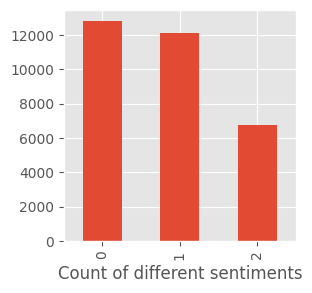

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

ax = df['category'].value_counts().sort_index().plot(kind='bar',figsize=(3,3))
ax.set_xlabel('Count of different sentiments')

In [8]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['clean_comment', 'category', '__index_level_0__'],
    num_rows: 31679
})

In [9]:
from transformers import AutoTokenizer, DataCollatorWithPadding
checkpoint = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator=DataCollatorWithPadding(tokenizer=tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\johna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
def tokenize_function(x):
    return tokenizer(x['clean_comment'],truncation=True)

tok_ds = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/31679 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [11]:
tok_ds = tok_ds.remove_columns(['clean_comment','__index_level_0__'])
tok_ds = tok_ds.rename_columns({'category':'labels'})
tok_ds.set_format('torch')

In [12]:
dds = tok_ds.train_test_split(test_size=0.25,seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 23759
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7920
    })
})

In [13]:
import torch
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dds['train'],shuffle=True,batch_size=8,collate_fn=data_collator)

test_dataloader = DataLoader(
    dds['test'],batch_size=8,collate_fn=data_collator)

#get first batch
batch = next(iter(train_dataloader))
print(batch)

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': tensor([0, 0, 1, 1, 1, 2, 1, 0]), 'input_ids': tensor([[    1,   272,   311,  4210,  2187,  1528, 16482,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  2165, 34964,   303, 61700,  1385,   292,   262,  8684,   734,
          1219, 53647,  6132, 64760, 44445, 53647,  4797,  4733,  6225,   547,
             2,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    1,  7381,  9497,  9497,   291,  1850, 10431,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [    1,   275,   262, 123

In [14]:
for batch in train_dataloader:
    break

{k:v.shape for k,v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 47]),
 'token_type_ids': torch.Size([8, 47]),
 'attention_mask': torch.Size([8, 47])}

In [15]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3) 

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

In [16]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.0966, grad_fn=<NllLossBackward0>) torch.Size([8, 3])


In [17]:
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5)

In [18]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
"linear",
optimizer=optimizer,
num_warmup_steps=0,
num_training_steps=num_training_steps)

print(num_training_steps)

8910


In [19]:
import torch

device = "cuda" if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)

cuda


In [20]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/8910 [00:00<?, ?it/s]

In [21]:
import evaluate

metric = evaluate.load('accuracy')

In [22]:
model.eval()
for batch in test_dataloader:
    batch = {k:v.to(device) for k,v in batch.items()}
    with torch.inference_mode():
        outputs = model(**batch)
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch['labels'])
    
    
print(metric.compute())

{'accuracy': 0.9611111111111111}


In [23]:
from huggingface_hub import notebook_login
notebook_login()

model.push_to_hub('Reddit_Sentiment_Analysis_V2')

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/738M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jgalford/Reddit_Sentiment_Analysis_V2/commit/33ee55896e53dea7f5ce3f6b1a26596126f50a45', commit_message='Upload DebertaV2ForSequenceClassification', commit_description='', oid='33ee55896e53dea7f5ce3f6b1a26596126f50a45', pr_url=None, pr_revision=None, pr_num=None)

In [3]:
from transformers import pipeline

reddit_sentiment_model = pipeline('sentiment-analysis',
                                  model='jgalford/Reddit_Sentiment_Analysis_V2',
                                  tokenizer='microsoft/deberta-v3-base')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
C:\Users\johna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
# Example
reddit_sentiment_model(['I love this movie',
                        'I hate this movie',
                        'I am neutral about this movie'])

[{'label': 'LABEL_1', 'score': 0.99540776014328},
 {'label': 'LABEL_2', 'score': 0.9997060894966125},
 {'label': 'LABEL_0', 'score': 0.9405978322029114}]

In [14]:
# Expected: 1
# Expected: 2
# Expected: 0

reddit_sentiment_model(['family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches',
                        'seriously don say thing first all they won get its too complex explain normal people anyway and they are dogmatic then doesn matter what you say see mechante post and for any reason you decide later life move from buddhism and that doesn suit you identity though you still get keep all the wisdom then your family will treat you like you went through weird hippy phase for while there didncha and you never hear the end pro tip don put one these your wall jpg',
                        'what you have learned yours and only yours what you want teach different focus the goal not the wrapping paper buddhism can passed others without word about the buddha'])

[{'label': 'LABEL_1', 'score': 0.9955938458442688},
 {'label': 'LABEL_2', 'score': 0.998806357383728},
 {'label': 'LABEL_0', 'score': 0.9836848974227905}]

In [15]:

for comment in df[df['category'] == 2]['clean_comment'].head(10):
    print(reddit_sentiment_model(comment))

print('\n')

for comment in df[df['category'] == 1]['clean_comment'].head(10):
    print(reddit_sentiment_model(comment))

print('\n')

for comment in df[df['category'] == 0]['clean_comment'].head(10):
    print(reddit_sentiment_model(comment))

[{'label': 'LABEL_2', 'score': 0.9994538426399231}]
[{'label': 'LABEL_2', 'score': 0.9997095465660095}]
[{'label': 'LABEL_2', 'score': 0.9997026324272156}]
[{'label': 'LABEL_2', 'score': 0.9996123909950256}]
[{'label': 'LABEL_2', 'score': 0.9996707439422607}]
[{'label': 'LABEL_2', 'score': 0.9995797276496887}]
[{'label': 'LABEL_2', 'score': 0.9992075562477112}]
[{'label': 'LABEL_2', 'score': 0.998730480670929}]
[{'label': 'LABEL_2', 'score': 0.9994460940361023}]
[{'label': 'LABEL_2', 'score': 0.999612033367157}]


[{'label': 'LABEL_1', 'score': 0.9955938458442688}]
[{'label': 'LABEL_1', 'score': 0.9987039566040039}]
[{'label': 'LABEL_1', 'score': 0.9988044500350952}]
[{'label': 'LABEL_1', 'score': 0.997711181640625}]
[{'label': 'LABEL_1', 'score': 0.9935490489006042}]
[{'label': 'LABEL_1', 'score': 0.9932107329368591}]
[{'label': 'LABEL_1', 'score': 0.9959259033203125}]
[{'label': 'LABEL_1', 'score': 0.9981526732444763}]
[{'label': 'LABEL_1', 'score': 0.9975976347923279}]
[{'label': 'L